# ==================================================

# Task 4

In [1]:
### import os
import wer
import openfst_python as fst
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from vetrbi import MyViterbiDecoder
from utils import parse_lexicon, generate_symbol_tables
from hmm import generate_word_sequence_recognition_wfst
from hmm import generate_word_sequence_recognition_wfst_with_silance
from hmm import generate_bigram_wfst

from utils import draw
import numpy as np
import pickle


def create_wfst():
    f = generate_word_sequence_recognition_wfst(3)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_wfst_with_silance():
    f = generate_word_sequence_recognition_wfst_with_silance(3, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f




def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

def memory_of_wfst(f):
    '''
    Compute a measure of the memory required for your decoder by providing counts
    of number of states and arcs in the WFST.
    '''
    all_states = []
    all_arcs = []
    for state in f.states():
        all_states.append(state)
        for arc in f.arcs(state):
            all_arcs.append(arc)
    return len(all_states), len(all_arcs)
    
def get_avg_wer(all_losses, verbose=False):
    all_wer = []
    for error_counts, word_count in all_losses:
        all_wer.append(sum(error_counts) / word_count)
    
    if verbose :
        print(f'The average WER is {np.mean(all_wer):.2%}')    
    return np.mean(all_wer)

def get_avg_effciency(efficancy_measures, verbose=False):
    decoding_time = np.mean(efficancy_measures[0])
    backtrace_time = np.mean(efficancy_measures[1])
    number_of_computions = np.mean(efficancy_measures[2])
    if verbose:
        print(f'The average decoding time is {decoding_time:.2f} seconds')
        print(f'The average backtrace time is {backtrace_time:.2f} seconds')
        print(f'The average number of computations is {number_of_computions:.2f}')
    return decoding_time, backtrace_time, number_of_computions


def decoding_loop(f, train_set=True, train_split=0.5, use_pruning=False, determinized=False, verbose=False, prune_threshold= None, bigram = False):
    all_losses = []
    decoding_time = []
    backtrace_time = []
    number_of_computations = []
    all_files = glob.glob('/group/teaching/asr/labs/recordings/*.wav')
    train_files = all_files[:(int(train_split*len(all_files)))]
    test_files = all_files[(int(train_split*len(all_files))):]
    
    if train_set:
        files= train_files
    else:
        files = test_files
    
    for wav_file in tqdm(files):    
        decoder  = MyViterbiDecoder(f, wav_file, verbose=verbose, use_pruning=use_pruning, determinized=determinized, bigram=bigram)
        if use_pruning and prune_threshold!=None:
            decoder.prune_threshold = prune_threshold
        decoder.decode()
        (state_path, words) = decoder.backtrace()  
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        all_losses.append((error_counts, word_count))
        decoding_time.append(decoder.decode_time)
        backtrace_time.append(decoder.backtrace_time)
        number_of_computations.append(decoder.number_of_computiations)
        if verbose:
            print(f'Transcription: {transcription} || Prediction: {words} || (nsub, ndel, nin) :{error_counts}')
    
    efficancy_measures = (decoding_time, backtrace_time, number_of_computations)
    return all_losses, efficancy_measures


lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
f = create_wfst()
f_silence = create_wfst_with_silance()
f_det = fst.determinize(f)

 85%|████████████████████████████████▏     | 269/318 [00:00<00:00, 29027.45it/s]


In [ ]:
exp_dict= {
    'loss' : [],
    'efficancy':[],
    'acc': [],
    'm1': [],
    'm2': [],
    'm3': [],
    'all_states': [],
    'all_arcs': [],
    'det': False,
    'n': 0   
}


def create_bigram_lexical(n):
    f = generate_bigram_wfst(n)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

ns = [1,2,3]

for n in ns:
    print(f'N = {n}')
    f_bigram = create_bigram_lexical(n)
    exp_dict['n'] = n
    det = False
    exp_dict['det'] = det
    exp_dict['all_states'], exp_dict['all_arcs'] = memory_of_wfst(f_bigram)
    verbose = True
    print(f'det = {det}')
    print(f'All states: {exp_dict["all_states"]}, all arcs: {exp_dict["all_arcs"]}')
    all_losses, efficancy_measures = decoding_loop(f_bigram, train_set=True, train_split=0.05, determinized=det, verbose=verbose, bigram=True)
    avg_wer = get_avg_wer(all_losses, verbose=True)
    m1,m2,m3 = get_avg_effciency(efficancy_measures, verbose=verbose)
    exp_dict['loss'].append(all_losses)
    exp_dict['efficancy'].append(efficancy_measures)
    exp_dict['acc'].append(avg_wer)
    exp_dict['m1'].append(m1)
    exp_dict['m2'].append(m2)
    exp_dict['m3'].append(m3)

    print('\n\n\n')
    file_name = f'exp_dict_baseline_det_{det}_bigram_{n}.pkl'
    with open(file_name, 'wb') as handler:
        pickle.dump(exp_dict, handler)
    print(f'saved to {file_name}')



N = 1
det = False
All states: 764, all arcs: 1516


  7%|██▉                                         | 1/15 [00:14<03:26, 14.76s/it]

Decoding took 13.445321559906006 seconds
Number of computations: 387244
Phones:  ['', ' p ay p er ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' ey ', ' p eh k ', ' ah v ', ' dh iy ', ' p ih k ah l d ', ' p ay p er ', ' dh iy ', ' ah v ', ' p iy t er ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' w eh r z ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', '']
best_out_sequence:  sil p ay p er sil p ih k t sil ey sil p eh k sil ah v sil dh iy sil p eh k sil ah v sil dh iy sil p eh k sil ah v sil p ih k ah l d sil ey sil p eh k sil ah v sil dh iy sil p ih k ah l d sil p ay p er sil dh iy sil ah v sil p iy t er sil p ih k t sil ey sil p eh k sil ah v sil p ih k ah l d sil w eh r z sil dh iy sil p ih k t sil ey sil p eh k sil p ih k t sil
best_state_sequence:  [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 367, 368, 369, 370, 371, 372, 373, 373, 373, 574, 575, 576, 577, 57

 13%|█████▊                                      | 2/15 [00:24<02:35, 12.00s/it]

Decoding took 9.187397718429565 seconds
Number of computations: 261592
Phones:  ['', ' dh iy ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' ah v ', ' w eh r z ', ' dh iy ', ' p ih k t ', ' w eh r z ', ' p iy t er ', ' p ay p er ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k t ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil dh iy sil p eh k sil ah v sil dh iy sil p eh k sil ah v sil w eh r z sil dh iy sil p ih k t sil w eh r z sil p iy t er sil p ay p er sil p ih k t sil ey sil p eh k sil ah v sil dh iy sil p eh k sil ah v sil p ih k t sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 754, 625, 626, 627, 628, 628, 629, 630, 169, 170, 171, 172, 173, 150, 151, 152, 153, 154, 625, 626, 627, 628, 629, 629, 630, 630, 169, 170, 171, 172, 173, 156, 157, 158, 159, 160, 161, 162, 750, 750, 751, 752, 753, 754, 754, 754, 754, 754, 649, 650, 651, 652, 653, 654, 655, 456, 456, 456, 456, 456, 

 20%|████████▊                                   | 3/15 [00:36<02:24, 12.03s/it]

Decoding took 11.132612466812134 seconds
Number of computations: 319324
Phones:  ['', ' dh iy ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' p iy t er ', ' p ih k t ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', '']
best_out_sequence:  sil dh iy sil p eh k sil p ih k t sil ey sil p eh k sil ah v sil dh iy sil p eh k sil p iy t er sil p ih k t sil p eh k sil p ih k t sil ey sil p eh k sil ah v sil dh iy sil p ih k t sil ey sil p eh k sil p ih k t sil ey sil p eh k sil ah v sil
best_state_sequence:  [-1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 754, 625, 626, 627, 628, 629, 630, 199, 200, 201, 202, 203, 204, 205, 389, 390, 391, 392, 392, 25, 26, 27, 28, 29, 30, 169, 170, 171, 172, 173, 150, 150, 151, 152, 153, 154, 625, 626, 627, 628, 629, 630, 630, 630, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191

 27%|███████████▋                                | 4/15 [00:49<02:14, 12.21s/it]

Decoding took 11.470536708831787 seconds
Number of computations: 329512
Phones:  ['', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p eh p er z ', ' w eh r z ', ' dh iy ', ' p eh k ', ' dh iy ', ' p eh k ', ' ah v ', ' w eh r z ', ' dh iy ', ' p ih k t ', ' w eh r z ', ' dh iy ', ' p eh k ', ' ah v ', ' w eh r z ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', '']
best_out_sequence:  sil p ih k t sil ey sil p eh k sil ah v sil p ih k ah l d sil p eh p er z sil w eh r z sil dh iy sil p eh k sil dh iy sil p eh k sil ah v sil w eh r z sil dh iy sil p ih k t sil w eh r z sil dh iy sil p eh k sil ah v sil w eh r z sil dh iy sil p eh k sil ah v sil p ih k t sil dh iy sil p ih k t sil ey sil p eh k sil p ih k t sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 349, 350, 351, 352, 353, 354, 355, 389, 390, 391, 391, 392, 25, 26, 27, 28, 29, 30, 169, 170, 171, 172, 173, 132, 133, 134, 135,

 33%|██████████████▋                             | 5/15 [01:03<02:08, 12.85s/it]

Decoding took 12.641878843307495 seconds
Number of computations: 368000
Phones:  ['', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' dh iy ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' p ih k t ', ' dh iy ', ' p ay p er ', ' p ih k t ', ' p ih k ah l d ', ' p eh p er z ', ' w eh r z ', ' p iy t er ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil dh iy sil p ih k t sil ey sil p eh k sil dh iy sil p eh k sil p ih k t sil ey sil p eh k sil ah v sil p ih k t sil dh iy sil p ay p er sil p ih k t sil p ih k ah l d sil p eh p er z sil w eh r z sil p iy t er sil p ih k t sil ey sil p eh k sil p ih k t sil dh iy sil p eh k sil p ih k t sil ey sil p eh k sil p ih k t sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 754, 649, 650, 651, 652, 653, 654, 655, 389, 390, 391, 392, 25, 26, 27, 28, 29, 3

 40%|█████████████████▌                          | 6/15 [01:29<02:35, 17.25s/it]

Decoding took 23.67314577102661 seconds
Number of computations: 677036
Phones:  ['', ' dh iy ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' dh iy ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' ah v ', ' p ay p er ', ' ah v ', ' p ih k ah l d ', ' ah v ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' ey ', ' p ih k ah l d ', ' p eh p er z ', ' w eh r z ', ' dh iy ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', '']
best_out_sequence:  sil dh iy sil p ih k t sil dh iy sil p ih k t sil dh iy sil p eh k sil p ih k t sil ey sil p eh k sil ah v sil dh iy sil p eh k sil ah v sil p ih k ah l d sil dh iy sil p eh k sil ah v sil p ih k ah l d sil ah v sil p ay p er sil ah v sil p ih k ah l d sil ah v sil p eh k sil ah v sil p ih k ah l d sil ey sil p ih k ah l d sil p eh p er z sil w eh r z sil dh iy sil p eh k sil p ih k t sil ey s

 47%|████████████████████▌                       | 7/15 [01:45<02:14, 16.84s/it]

Decoding took 14.640849351882935 seconds
Number of computations: 415544
Phones:  ['', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' dh iy ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p eh k ', ' p ih k ah l d ', ' p ih k t ', ' w eh r z ', ' p ih k ah l d ', ' w eh r z ', ' p ih k ah l d ', ' p ay p er ', ' p ih k t ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' w eh r z ', ' dh iy ', '']
best_out_sequence:  sil dh iy sil p ih k t sil ey sil p eh k sil dh iy sil p eh k sil p ih k t sil dh iy sil p eh k sil p ih k ah l d sil p ih k t sil w eh r z sil p ih k ah l d sil w eh r z sil p ih k ah l d sil p ay p er sil p ih k t sil p ih k t sil ey sil p eh k sil p ih k t sil w eh r z sil dh iy sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 750, 750, 750, 751, 752, 753, 754, 649, 650, 651, 652, 653, 654, 655, 389, 390, 391, 392, 25, 26, 27, 28, 29, 30, 225, 225, 226, 227, 228, 229, 229, 229, 229, 625, 626, 627, 628, 629, 630, 630, 630, 630, 1

 53%|███████████████████████▍                    | 8/15 [02:04<02:02, 17.48s/it]

Decoding took 17.154993534088135 seconds
Number of computations: 493652
Phones:  ['', ' dh iy ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p ih k t ', ' w eh r z ', ' p ih k ah l d ', ' ah v ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p ih k t ', ' p eh p er z ', ' p ih k t ', ' p ay p er ', ' p ih k t ', ' ey ', ' p ih k t ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil dh iy sil p eh k sil p ih k t sil dh iy sil p eh k sil ah v sil p ih k ah l d sil p ih k t sil w eh r z sil p ih k ah l d sil ah v sil p eh k sil ah v sil p ih k ah l d sil p ih k t sil p eh p er z sil p ih k t sil p ay p er sil p ih k t sil ey sil p ih k t sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 753, 754, 754, 625, 626, 627, 628, 629, 630, 630, 630, 199, 200, 200, 201, 202, 203, 204, 205, 450, 451, 452, 453, 454, 625, 626, 627, 628, 629, 630, 169, 170, 171, 172, 173, 132, 133, 134, 135, 136,

 60%|██████████████████████████▍                 | 9/15 [02:22<01:47, 17.86s/it]

Decoding took 17.213226318359375 seconds
Number of computations: 493652
Phones:  ['', ' p ay p er ', ' p ih k t ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k t ', ' p iy t er ', ' p ih k t ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p eh p er z ', ' w eh r z ', ' dh iy ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil p ay p er sil p ih k t sil dh iy sil p eh k sil ah v sil p ih k t sil p iy t er sil p ih k t sil p eh k sil ah v sil p ih k ah l d sil p eh p er z sil w eh r z sil dh iy sil p eh k sil p ih k t sil dh iy sil p ih k t sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 367, 368, 369, 370, 371, 372, 373, 574, 575, 576, 577, 578, 579, 580, 450, 450, 450, 450, 451, 452, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 453, 454, 625, 626, 627, 628, 629, 630, 169, 170, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 124, 125, 126, 127, 128, 129

 67%|████████████████████████████▋              | 10/15 [02:39<01:27, 17.53s/it]

Decoding took 15.172991514205933 seconds
Number of computations: 444976
Phones:  ['', ' dh iy ', ' p ih k t ', ' w eh r z ', ' dh iy ', ' p eh k ', ' p ih k ah l d ', ' w eh r z ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p ih k t ', ' ey ', ' p eh k ', ' dh iy ', ' p eh k ', ' ah v ', ' w eh r z ', ' dh iy ', ' p eh k ', ' dh iy ', ' p eh k ', ' ah v ', ' dh iy ', '']
best_out_sequence:  sil dh iy sil p ih k t sil w eh r z sil dh iy sil p eh k sil p ih k ah l d sil w eh r z sil dh iy sil p eh k sil ah v sil p ih k ah l d sil p ih k t sil ey sil p eh k sil dh iy sil p eh k sil ah v sil w eh r z sil dh iy sil p eh k sil dh iy sil p eh k sil ah v sil dh iy sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 753, 754, 649, 650, 651, 652, 653, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 655, 456, 456, 456, 456, 456, 456, 456, 

 73%|███████████████████████████████▌           | 11/15 [02:55<01:08, 17.09s/it]

Decoding took 14.619221687316895 seconds
Number of computations: 425732
Phones:  ['', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p eh p er z ', ' p ih k t ', ' p eh k ', ' p iy t er ', ' p ay p er ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' w eh r z ', ' dh iy ', '']
best_out_sequence:  sil dh iy sil p ih k t sil ey sil p eh k sil p ih k t sil dh iy sil p eh k sil ah v sil p ih k ah l d sil p eh p er z sil p ih k t sil p eh k sil p iy t er sil p ay p er sil p ih k t sil ey sil p eh k sil ah v sil w eh r z sil dh iy sil
best_state_sequence:  [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 753, 754, 649, 650, 651, 652, 653, 654, 655, 389, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 392, 25, 26, 27, 28, 29, 30, 199, 200, 201, 202, 203, 204, 205, 450, 450, 451, 452, 453, 454, 625, 626, 627, 628, 629, 630, 169, 170, 171, 172, 173, 

 80%|██████████████████████████████████▍        | 12/15 [03:22<00:59, 19.98s/it]

Decoding took 24.360478162765503 seconds
Number of computations: 696280
Phones:  ['', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' p iy t er ', ' p ay p er ', ' p ih k t ', ' p ih k t ', ' ey ', ' p ih k t ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p eh p er z ', ' w eh r z ', ' dh iy ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p eh p er z ', ' p eh k ', ' p iy t er ', ' p ay p er ', ' p ih k t ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil dh iy sil p ih k t sil ey sil p eh k sil ah v sil p iy t er sil p ay p er sil p ih k t sil p ih k t sil ey sil p ih k t sil p eh k sil ah v sil p ih k ah l d sil p eh p er z sil w eh r z sil dh iy sil p eh k sil p ih k t sil dh iy sil p eh p er z sil p eh k sil p iy t er sil p ay p er sil p ih k t sil p ih k t sil dh iy sil p ih k t sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 754, 649, 650, 651, 652, 653, 654, 655, 389,

 87%|█████████████████████████████████████▎     | 13/15 [03:35<00:35, 17.85s/it]

Decoding took 11.770739555358887 seconds
Number of computations: 338568
Phones:  ['', ' dh iy ', ' p eh k ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' dh iy ', ' p eh k ', ' p ih k t ', ' p iy t er ', ' p ay p er ', ' ah v ', ' p ih k t ', ' ey ', ' p eh k ', ' p eh p er z ', '']
best_out_sequence:  sil dh iy sil p eh k sil p ih k t sil ey sil p eh k sil p ih k t sil dh iy sil p ih k t sil ey sil p eh k sil dh iy sil p eh k sil p ih k t sil p iy t er sil p ay p er sil ah v sil p ih k t sil ey sil p eh k sil p eh p er z sil
best_state_sequence:  [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 754, 625, 626, 627, 628, 629, 629, 630, 199, 200, 201, 202, 203, 204, 205, 389, 390, 391, 391, 391, 391, 392, 25, 26, 27, 28, 29, 30, 199, 200, 201, 202, 203, 204, 204, 205, 450, 451, 452, 453, 453, 453, 453, 453, 453, 453, 454, 649, 650, 651, 652, 653, 654, 655, 389, 390, 391, 391, 391, 391, 391, 391, 391,

 93%|████████████████████████████████████████▏  | 14/15 [03:55<00:18, 18.75s/it]

Decoding took 19.043327569961548 seconds
Number of computations: 551384
Phones:  ['', ' p ay p er ', ' p ih k t ', ' dh iy ', ' p eh k ', ' ah v ', ' dh iy ', ' p eh k ', ' p ih k t ', ' ah v ', ' p ih k ah l d ', ' p eh k ', ' ah v ', ' p eh p er z ', ' w eh r z ', ' dh iy ', ' p eh p er z ', ' p ih k t ', ' w eh r z ', ' p ih k ah l d ', ' p ih k ah l d ', ' ey ', ' p eh k ', ' ah v ', ' p ay p er ', ' p ih k t ', ' ey ', ' p eh k ', ' ah v ', ' w eh r z ', ' dh iy ', ' p eh k ', '']
best_out_sequence:  sil p ay p er sil p ih k t sil dh iy sil p eh k sil ah v sil dh iy sil p eh k sil p ih k t sil ah v sil p ih k ah l d sil p eh k sil ah v sil p eh p er z sil w eh r z sil dh iy sil p eh p er z sil p ih k t sil w eh r z sil p ih k ah l d sil p ih k ah l d sil ey sil p eh k sil ah v sil p ay p er sil p ih k t sil ey sil p eh k sil ah v sil w eh r z sil dh iy sil p eh k sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 367, 367, 368, 369, 370, 371, 372, 373, 

100%|███████████████████████████████████████████| 15/15 [04:08<00:00, 16.59s/it]


Decoding took 11.814109802246094 seconds
Number of computations: 338568
Phones:  ['', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' dh iy ', ' p eh k ', ' p ih k t ', ' p ih k t ', ' p ih k ah l d ', ' p eh k ', ' dh iy ', ' p eh k ', ' p ih k ah l d ', ' w eh r z ', ' dh iy ', ' p ih k ah l d ', '']
best_out_sequence:  sil dh iy sil p ih k t sil ey sil p eh k sil p ih k t sil dh iy sil p ih k t sil dh iy sil p eh k sil p ih k t sil p ih k t sil p ih k ah l d sil p eh k sil dh iy sil p eh k sil p ih k ah l d sil w eh r z sil dh iy sil p ih k ah l d sil
best_state_sequence:  [-1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 750, 751, 752, 753, 754, 649, 650, 651, 652, 653, 654, 655, 389, 390, 391, 392, 392, 392, 25, 26, 27, 28, 29, 30, 199, 200, 201, 202, 203, 204, 205, 450, 451, 452, 453, 454, 454, 454, 649, 650, 651, 652, 653, 654, 655, 450, 451, 452, 453, 454, 454, 454, 454, 625, 626, 627, 628, 629, 630, 199, 200, 200, 200, 200, 200, 200,

  7%|██▉                                         | 1/15 [00:20<04:52, 20.91s/it]

Decoding took 19.629092931747437 seconds
Number of computations: 592368
Phones:  ['', ' dh iy ', ' p ih k t ', ' dh iy ', ' p eh k ', ' dh iy ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p ay p er ', ' dh iy ', ' ah v ', ' p iy t er ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' dh iy ', ' p ih k t ', ' ey ', '']
best_out_sequence:  sil dh iy sil p ih k t sil dh iy sil p eh k sil dh iy sil p eh k sil ah v sil p ih k ah l d sil p ay p er sil dh iy sil ah v sil p iy t er sil p ih k t sil dh iy sil p ih k t sil dh iy sil p ih k t sil ey sil
best_state_sequence:  [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1094, 1095, 1096, 1097, 1098, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 654, 654, 655, 656, 657, 658, 659, 660, 660, 660, 908, 909, 910, 911, 912, 913, 914, 915, 916, 324, 324, 325, 326, 327, 328, 328, 329, 329, 329, 330, 9

 13%|█████▊                                      | 2/15 [00:35<03:41, 17.03s/it]

Decoding took 13.40631365776062 seconds
Number of computations: 399006
Phones:  ['', ' dh iy ', ' p eh k ', ' ah v ', ' w eh r z ', ' p iy t er ', ' p ih k t ', ' ey ', ' p eh k ', ' dh iy ', ' p eh k ', '']
best_out_sequence:  sil dh iy sil p eh k sil ah v sil w eh r z sil p iy t er sil p ih k t sil ey sil p eh k sil dh iy sil p eh k sil
best_state_sequence:  [-1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1100, 1100, 1100, 908, 909, 910, 911, 912, 913, 914, 915, 916, 916, 916, 240, 241, 242, 243, 244, 245, 245, 245, 245, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 224, 224, 224, 225, 225, 225, 226, 227, 228, 228, 228, 228, 228, 228, 229, 229, 229, 229, 230, 231, 232, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044, 1044, 1044, 1045, 1045, 1045, 1046, 1046, 1046, 1047, 1

 20%|████████▊                                   | 3/15 [00:52<03:26, 17.18s/it]

Decoding took 16.34739589691162 seconds
Number of computations: 487848
Phones:  ['', ' dh iy ', ' p eh k ', ' p ih k t ', ' dh iy ', ' p iy t er ', ' p ih k t ', ' p eh k ', ' dh iy ', ' p ih k t ', ' ey ', ' p eh k ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil dh iy sil p eh k sil p ih k t sil dh iy sil p iy t er sil p ih k t sil p eh k sil dh iy sil p ih k t sil ey sil p eh k sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1094, 1095, 1096, 1097, 1098, 1099, 1099, 1099, 1099, 1100, 908, 909, 910, 911, 912, 913, 914, 915, 916, 916, 916, 916, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 293, 294, 654, 655, 656, 657, 658, 659, 660, 660, 660, 660, 660, 660, 660, 660, 932, 932, 932, 932, 932, 932, 932, 932, 932, 932, 932, 933, 933, 933, 934, 934, 934, 934, 934, 935, 935, 935, 935, 936, 936, 937, 937, 937, 937, 937, 937, 937, 937, 937, 937, 938, 939, 940, 941, 942, 504, 504, 504, 504, 504, 504, 504, 504, 504

# ======================================================

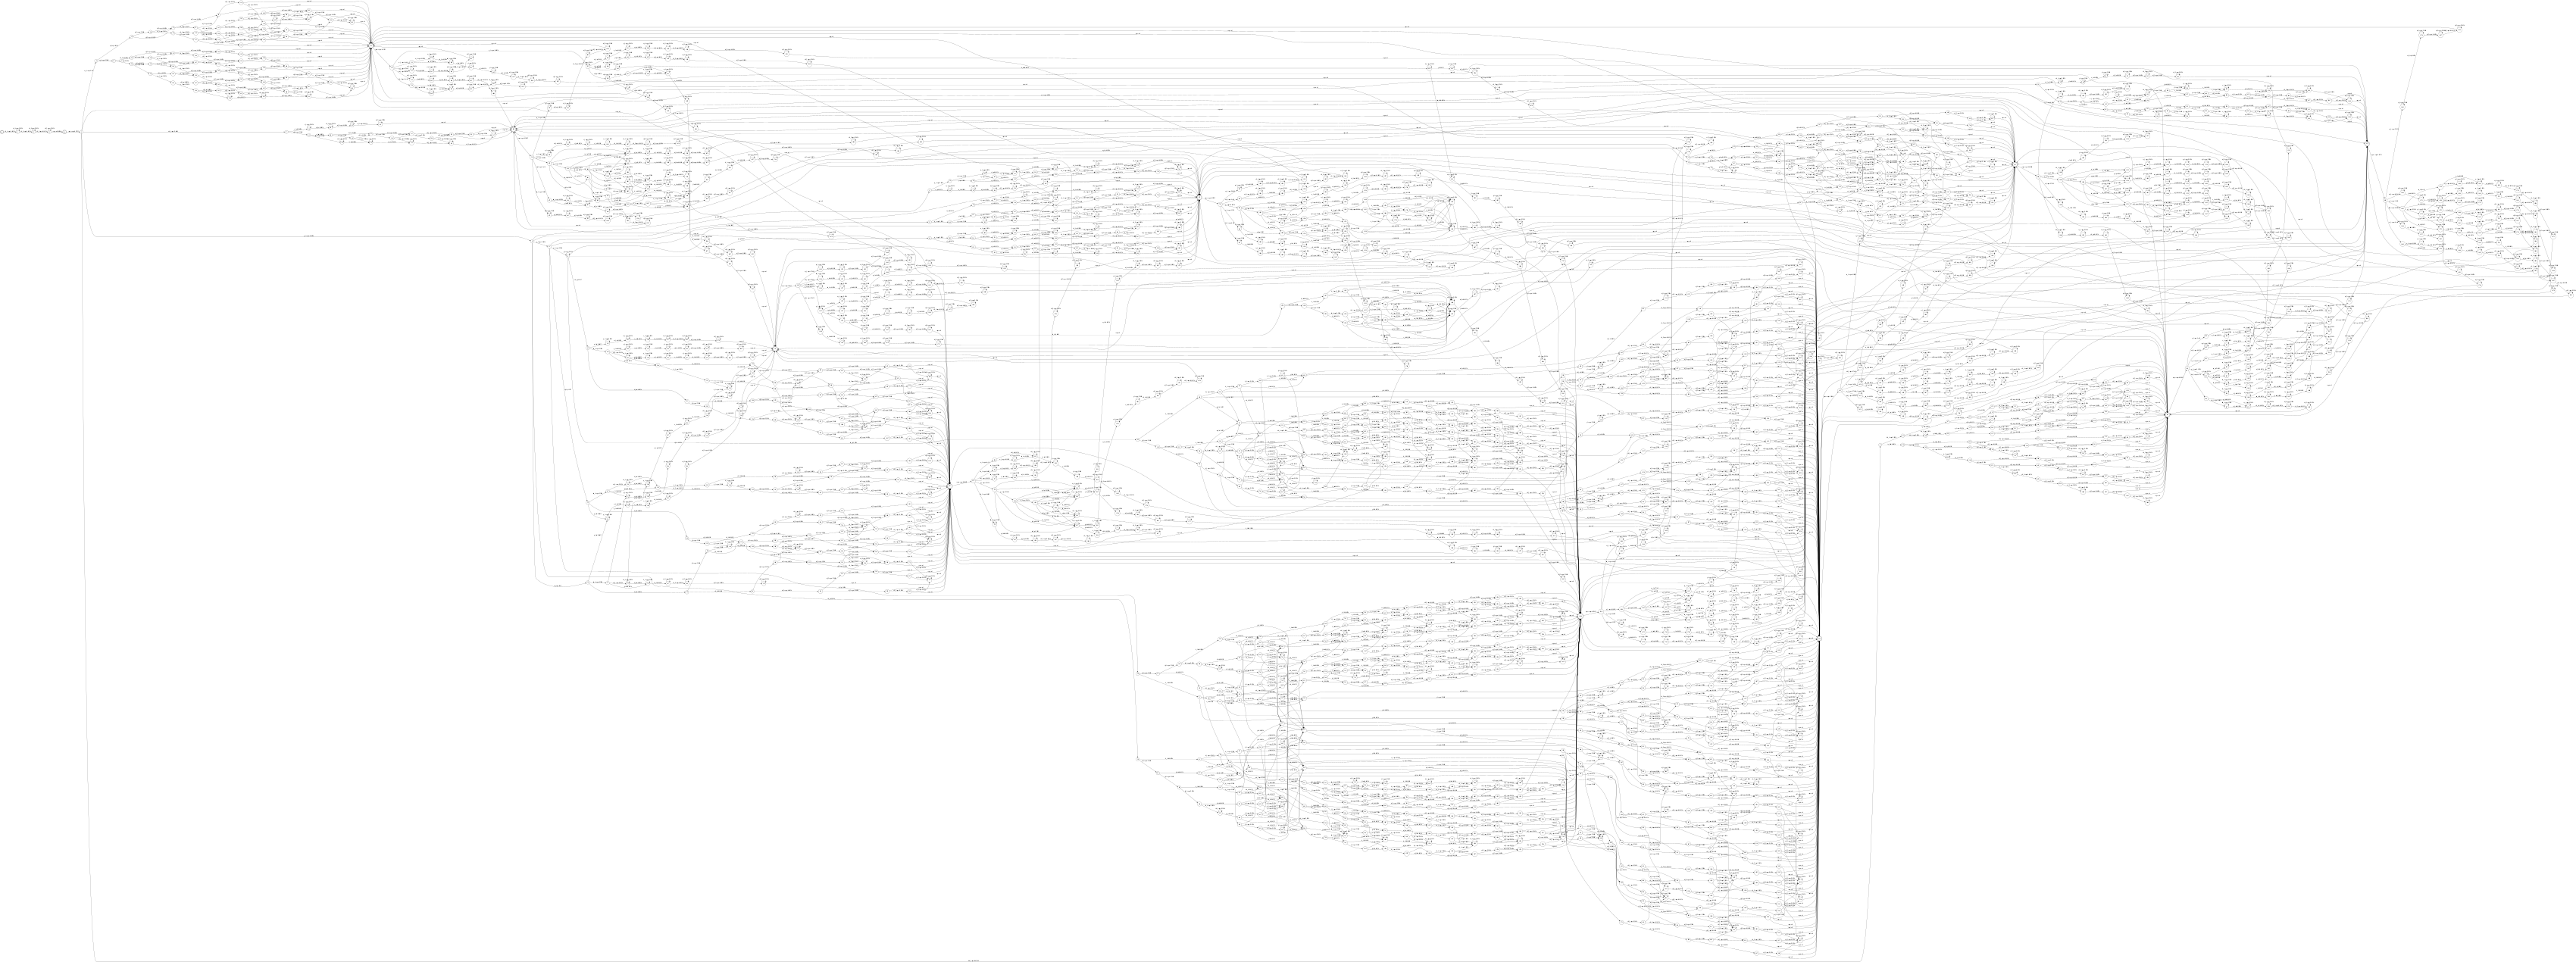

In [4]:
draw(f_bigram)